In [1]:
!pip install pandas-plink limix-lmm

In [2]:
import numpy as np
import pdb 
from pandas_plink import read_plink 
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd

In [3]:
import scipy
import scipy.stats as st
if not hasattr(scipy, 'dot'): scipy.dot = np.dot
if not hasattr(scipy, 'einsum'): scipy.einsum = np.einsum
if not hasattr(scipy, 'log'): scipy.log = np.log
if not hasattr(scipy, 'sign'): scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'): scipy.sqrt = np.sqrt

In [4]:
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip "https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1"

--2026-02-15 12:59:55--  https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1
Auflösen des Hostnamens www.dropbox.com (www.dropbox.com)… 2620:100:6022:18::a27d:4212, 162.125.66.18
Verbindungsaufbau zu www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1 [folgend]
--2026-02-15 12:59:56--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1
Wiederverwendung der bestehenden Verbindung zu [www.dropbox.com]:443.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://uc17454101657bab2cde26715a45.dl.dropboxusercontent.com/cd/0/inline/C69HOcOmQ19O2vTIUFdBGvez4zf7f06we7jP3RHnAygj_01OH9SuevLG2hhJwfbxL4e8vrxtQ9_fns_RVM4GsjJ4FJCbEpivMXOBx

In [5]:
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

In [6]:
bfile = 'ALL.chr22_GRCh38.genotypes.20170504' 
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 25.22it/s]
/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


print(len(bim))

G = G.compute()

snp_missing = np.mean(np.isnan(G), axis=1)  
keep_missing = snp_missing < 0.01           # missing rate > 0.01 (0.02, or 0.05) -> remove SNPs, that are missing in more than 1% of individuals

G = G[keep_missing, :]
bim = bim.loc[keep_missing].copy()
print(len(bim))
bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))

keep_unique = ~bim['snp'].duplicated()     # removing duplicated 
print(len(bim))

allele_freq = np.nanmean(G, axis=1) / 2.0     # Calculate allele frequency (values are 0, 1, 2 -> divide by 2)
maf = np.minimum(allele_freq, 1 - allele_freq)

keep_maf = maf > 0.02  # maf < 0.01 
print(len(bim))


filtered = keep_maf & keep_unique.values

G = G[filtered, :]
bim = bim.loc[filtered].copy()

bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))

print(len(bim))

In [7]:
bfile = 'data/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 34.37it/s]


In [8]:
def extract_region(bim, G, chrom, start, end): 
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values] 
    bim['i'] = np.arange(len(bim)) 
    return bim, G

In [9]:
def subset_individuals(fam, G, keep_idxs): 
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [29]:
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N]) 
fams, Gs = subset_individuals(bim, G, idxs)

In [30]:
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [10]:
X = G.T
print(X.shape)
def simulate_pheno(X, idx_caus, var_expl, direction=None):
# Ensure that the number of causal variant indices matches the number of variances explained. assert len(idx_caus) == len(var_expl)
    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
        # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)
        # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1. assert ve > 0, 'sum(var_expl) should be < 1'
        # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction
        # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)
        # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)
        # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn
        # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants. beta_real[idx_caus] = beta
        # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y. beta_real = beta_real / ystd
    return y, beta_real

(2504, 59743)


In [19]:
def qq_plot(p_values): 
    """
    Create a QQ plot given a list of p-values.
    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """
    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))
    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--') 
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')  

In [12]:
n_causal = 100
h2 = 0.1

heritability_values = [0.1,0.6]
n_causal_values = [10, 100]


idx_caus = np.random.choice(X.shape[1], size=n_causal) 
var_expl = np.full(n_causal, h2 / n_causal)
y, beta_real = simulate_pheno(X, idx_caus, var_expl)

In [13]:
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X)
pv = lmm.getPv()
beta = lmm.getBetaSNP() 
beta_ste = lmm.getBetaSNPste()

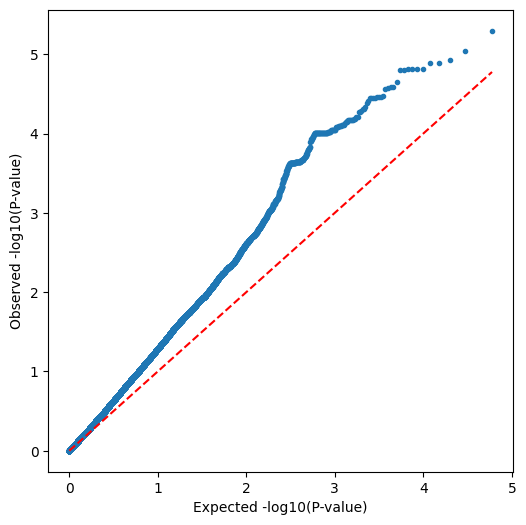

In [14]:
fig, ax = plt.subplots(figsize=(6, 6)) 
qq_plot(ax, pv)
plt.show()

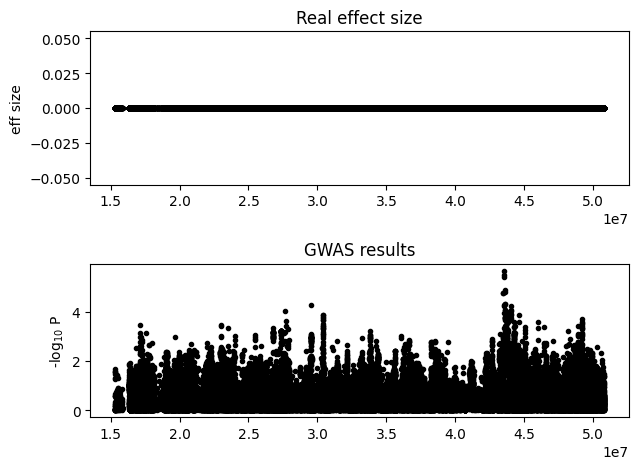

In [42]:
# Plot ground truth and results
x = bim['pos'].values 
plt.subplot(211) 
plt.title('Real effect size') 
plt.plot(x, beta_real, '.k') 
plt.ylabel('eff size') 
plt.subplot(212) 
plt.title('GWAS results') 
plt.plot(x, -np.log10(pv), '.k') 
plt.ylabel('-log$_{10}$ P') 
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape

((1752, 59743), (752, 59743))

In [16]:
# Perform genetic association testing
F = np.ones_like(y_train)
lmm = LMM(y_train, F)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP() 
beta_ste = lmm.getBetaSNPste()

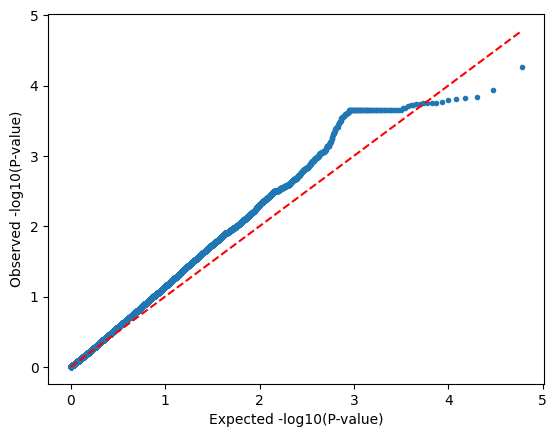

In [20]:
qq_plot(pv)
plt.show()

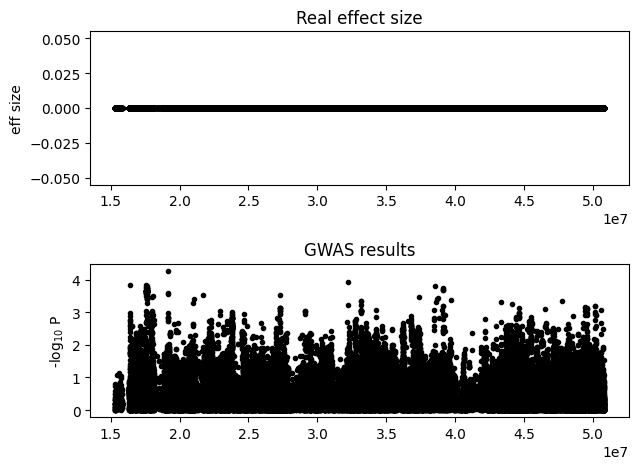

In [22]:
x = bim['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

In [23]:
df_plink = pd.DataFrame({
    'SNP': bim['snp'].astype(str), 
    'P': np.asarray(pv, dtype=float)
})

df_plink.to_csv("gwas.assoc", sep="\t", index=False)

plink --bfile  chr22_step3_sampleqc \                     ### The LD reference panel
         --clump gwas.assoc \                             ### Your summary stats file
         --clump-p1 5e-8 \                                ### Significance threshold for index SNPs
         --clump-p2 0.05 \                                ### Secondary significance threshold for clumped SNPs
         --clump-r2 0.1 \                                ### LD threshold for clumping
         --clump-kb 500 \
         --out chr22_GWAS_clumped_r0.1

         Options in effect:
  --bfile data/chr22_step3_sampleqc
  --clump gwas.assoc
  --clump-kb 250
  --clump-p1 1
  --clump-p2 1
  --clump-r2 0.1
  --out chr22_GWAS_clumped_r0.1

In [58]:
clumped = pd.read_csv("chr22_GWAS_clumped_r0.1.clumped", sep=r"\s+", engine="python")
clumped.head()
len(clumped)
lead_snps = clumped["SNP"].astype(str).tolist()
lead_snps
len(lead_snps)
is_clumped = bim['snp'].isin(lead_snps).values

In [ ]:
X_train_prs = X_train[:, is_clumped]
X_val_prs   = X_val[:, is_clumped]  

beta_prs = beta[is_clumped]

print(X_train_prs.shape)

Modell-Input Shape: (1752, 4297)


In [ ]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as st

/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/dask/array/core.py:1733: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


-0.6710380475963091
0.054952336745375856


/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/dask/array/core.py:1733: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


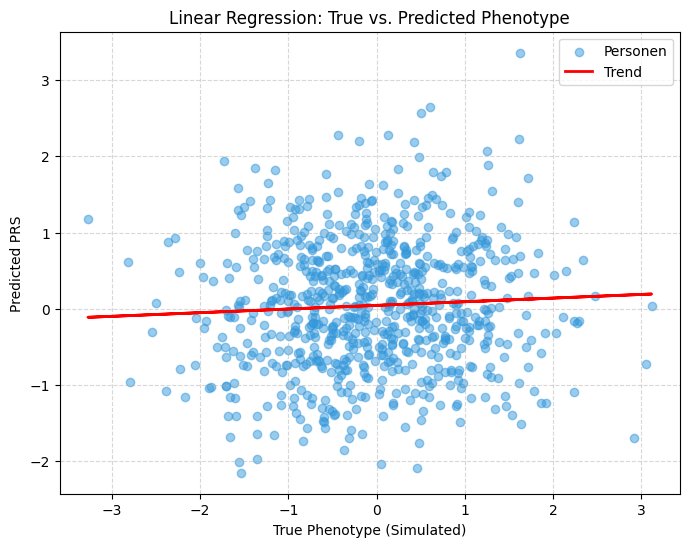

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prs, y_train.flatten())
y_pred_lin = lin_reg.predict(X_val_prs)
print(r2_score(y_val, y_pred_lin))
print(st.pearsonr(y_val.flatten(), y_pred_lin.flatten())[0])

plt.figure(figsize=(8, 6))

plt.scatter(y_val, y_pred_lin, alpha=0.5, color='#3498db', label='Personen')

m, b = np.polyfit(y_val.flatten(), y_pred_lin.flatten(), 1)
plt.plot(y_val, m*y_val + b, color='red', linewidth=2, label='Trend')

plt.title("Linear Regression: True vs. Predicted Phenotype")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Ridge Regression Corr:  0.0573


/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/dask/array/core.py:1733: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


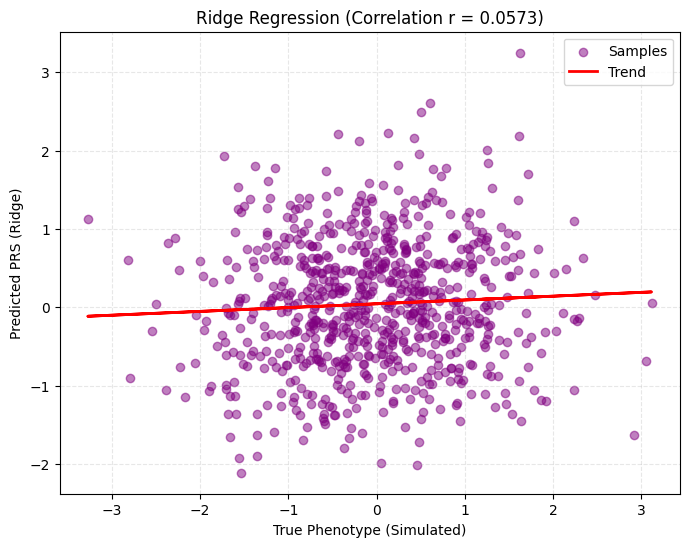

In [70]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5)
ridge.fit(X_train_prs, y_train.flatten())
y_pred_ridge = ridge.predict(X_val_prs)

print(f"Ridge Regression Corr:  {st.pearsonr(y_val.flatten(), y_pred_ridge.flatten())[0]:.4f}")

corr_ridge = st.pearsonr(y_val.flatten(), y_pred_ridge.flatten())[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_ridge, alpha=0.5, color='purple', label='Samples')

m, b = np.polyfit(y_val.flatten(), y_pred_ridge.flatten(), 1)
plt.plot(y_val, m*y_val + b, color='red', linewidth=2, label='Trend')

plt.title(f"Ridge Regression (Correlation r = {corr_ridge:.4f})")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS (Ridge)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

In [ ]:
y_pred_class = X_val_prs.dot(beta_prs)


lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_train_prs, y_train.flatten())
y_pred_lasso = lasso.predict(X_val_prs)

In [ ]:
def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    corr, p = st.pearsonr(y_true.flatten(), y_pred.flatten())
    print(f"--- {name} ---")
    print(f"  R² Score:      {r2:.4f}")
    print(f"  Correlation r: {corr:.4f} (P-Value: {p:.2e})")
    return corr

corr_class = evaluate_model(y_val, y_pred_class, "Classic PRS (GWAS Weights)")
corr_lasso = evaluate_model(y_val, y_pred_lasso, "Lasso Regression (ML)")

--- Classic PRS (GWAS Weights) ---
  R² Score:      -1828.8911
  Correlation r: 0.0580 (P-Value: 1.12e-01)
--- Lasso Regression (ML) ---
  R² Score:      -0.1336
  Correlation r: 0.0643 (P-Value: 7.83e-02)


/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/dask/array/core.py:1733: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/dask/array/core.py:1733: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


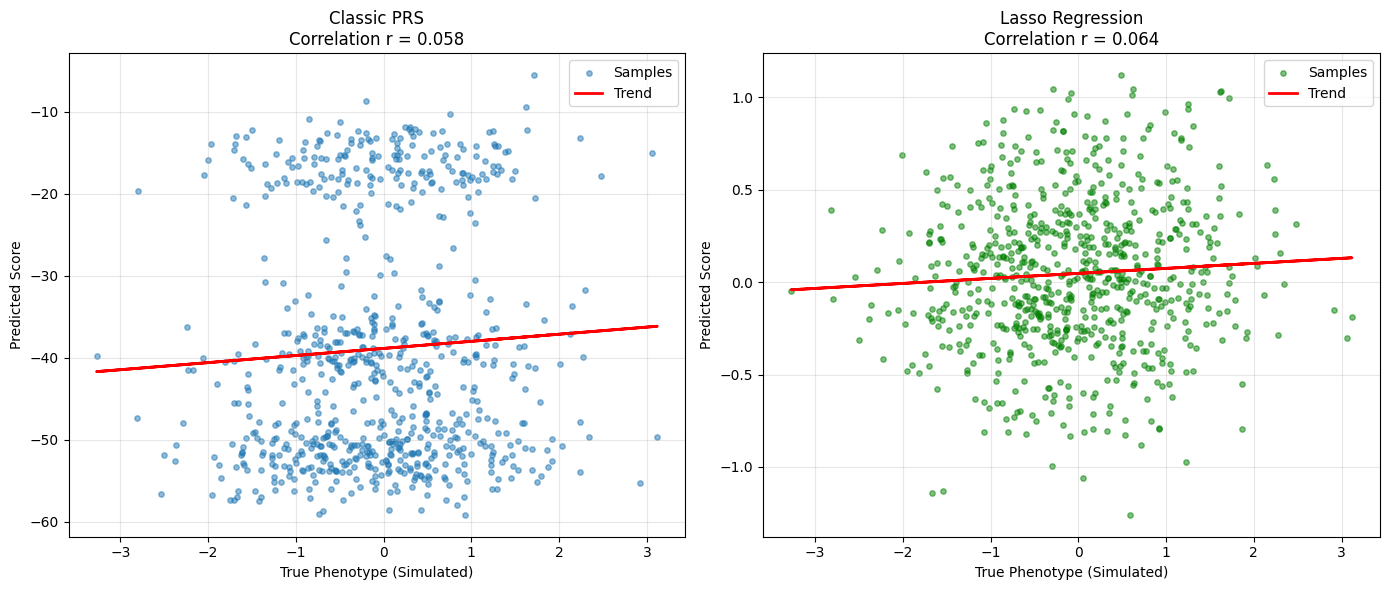

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_class, alpha=0.5, s=15, label='Samples')

m, b = np.polyfit(y_val.flatten(), y_pred_class.flatten(), 1)
plt.plot(y_val, m*y_val + b, color='red', lw=2, label='Trend')
plt.title(f"Classic PRS\nCorrelation r = {corr_class:.3f}")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted Score")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_lasso, alpha=0.5, s=15, color='green', label='Samples')

m, b = np.polyfit(y_val.flatten(), y_pred_lasso.flatten(), 1)
plt.plot(y_val, m*y_val + b, color='red', lw=2, label='Trend')
plt.title(f"Lasso Regression\nCorrelation r = {corr_lasso:.3f}")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted Score")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()